In [170]:
!pip install imblearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
# sklearn packages (for pre-processing, model-building, evaluators, cross-validators, etc.)
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder

# Imblearn packages (for over_sampling and imblearn pipelines)
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.pipeline import Pipeline, make_pipeline  ## Using packages from imblearn.pipeline for making pipelines

## xgboost packages
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

!pip install tqdm
from tqdm import tqdm

from random import sample

In [180]:
df_cct = pd.read_parquet("/home/onyxia/work/df_cct_2016.parquet")
df_nofraud = df_cct[df_cct["Is Fraud?"] == 0]
df_nofraud_sampled = df_nofraud.sample(int(0.95*(8412/0.05)), random_state = 0)

In [181]:
df_fraud = df_cct[df_cct["Is Fraud?"] == 1]
df_cct = pd.concat([df_nofraud_sampled, df_fraud], axis = 0).sort_index()

In [187]:
df_amount = pd.read_parquet("/home/onyxia/work/df_all.parquet")

In [211]:
df_cct["abs_amount"] = list(df_amount.loc[df_cct.index]["Amount"].abs().values)


,User,Card,Month,Day,Hours,year_diff,Amount,Use Chip,Card Brand,Card Type,...,nb_monthly_declines_card,bad_pin,insufficient_balance,hr_nbt/last_30d_av_hr_nbt,day_nbt/last_30d_av_day_nbt,last_3d_amt/nbt,label_global,Is Fraud?,pos_amount,abs_amount
15128,0,1,-1.000000,-1.000000,0.000000,0.00,0.642585,Chip Transaction,Visa,Debit,...,-0.5,0,0,-0.131161,0.256666,1.023525,0,0,1,129.62
15171,0,3,-1.000000,-0.133333,0.000000,0.25,0.852381,Swipe Transaction,Visa,Credit,...,0.5,0,0,3.072318,1.367775,1.024809,0,0,1,148.06
15190,0,2,-1.000000,0.266667,1.000000,1.25,-0.734627,Swipe Transaction,Visa,Debit,...,1.0,0,0,0.143653,-0.360069,-1.370792,0,0,1,8.57
15254,0,0,-0.833333,-0.600000,1.142857,0.75,-0.796632,Chip Transaction,Visa,Debit,...,0.0,0,0,0.430959,-0.392727,-0.790314,0,0,1,3.12
15307,0,3,-0.833333,0.400000,0.714286,0.25,-0.553388,Swipe Transaction,Visa,Credit,...,1.0,0,0,-0.184697,1.008809,-0.046252,0,0,1,24.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386541,1999,1,0.833333,-0.200000,0.000000,0.50,0.401095,Chip Transaction,Visa,Credit,...,-0.5,0,0,-0.082356,1.574706,0.710563,0,0,1,62.74
24386607,1999,1,0.833333,0.533333,0.916667,0.50,-0.107897,Chip Transaction,Visa,Credit,...,0.0,0,0,0.911591,0.770959,-0.345450,0,0,1,49.72
24386629,1999,1,0.833333,0.866667,-0.916667,0.50,7.044566,Online Transaction,Visa,Credit,...,0.0,0,0,-0.089590,0.727314,1.325470,1,0,1,232.68
24386804,1999,0,-0.833333,-0.666667,-0.750000,-0.50,9.034793,Chip Transaction,Mastercard,Debit,...,0.0,0,0,1.377210,-0.773035,11.317930,0,0,1,283.59


In [213]:
df_cct.reset_index(drop=True,inplace=True)

### One Hot Encoder

In [214]:
# For "Use Chip":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Use Chip"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [215]:
# For "Card Brand":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Brand"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [216]:
# For "Card Type":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["Card Type"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [217]:
# For "label global":

enc = OneHotEncoder(handle_unknown='ignore')

features_array = enc.fit_transform(df_cct[["label_global"]]).toarray()

features_labels = np.hstack(np.array(enc.categories_))

df_cct = pd.concat([df_cct, pd.DataFrame(features_array, columns = features_labels)], axis = 1)

In [218]:
df_cct.rename(columns={0:"0", -1: "-1", 1:"1", 2:"2", 3: "3", 4:"4", 5:"5", 6:"6"}, inplace=True)


In [219]:
df_cct.columns


Index(['User', 'Card', 'Month', 'Day', 'Hours', 'year_diff', 'Amount',
       'Use Chip', 'Card Brand', 'Card Type', 'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_daily_declines_card', 'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'label_global',
       'Is Fraud?', 'pos_amount', 'abs_amount', 'Chip Transaction',
       'Online Transaction', 'Swipe Transaction', 'Amex', 'Discover',
       'Mastercard', 'Visa', 'Credit', 'Debit', 'Debit (Prepaid)', '-1', '0',
       '1', '2', '3', '4', '5', '6'],
      dtype='object')

In [220]:
# selecting features
# dropped card, nb_weekly_declines, day_of_week, nb_daily_declines, credit, debit, amex,  discover,
# mastercard, visa
features = ['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"Is Fraud?",
        "-1","0","1","2","3","4","5","6"]

df_selec = df_cct[features] # 21 features + clusters

X = df_selec[['Month', 'Day', 'Hours', 'year_diff', 'Amount', 'pos_amount',
       'Credit Limit', 'delta_t_s',
       'delta_t_s_card', 'amt/daily_income', 'Retired', 'daily_amount',
       'nb_monthly_declines_card', 'bad_pin',
       'insufficient_balance', 'hr_nbt/last_30d_av_hr_nbt',
       'day_nbt/last_30d_av_day_nbt', 'last_3d_amt/nbt', 'Chip Transaction', 'Online Transaction',
       'Swipe Transaction','Debit (Prepaid)',"-1","0","1","2","3","4","5","6"]]
       
y = df_selec["Is Fraud?"]

In [222]:
## Splitting the data into train and test data  (70:30)

## Create a STRATIFIED train-test (Hence, passing the argument 'stratify= y')
# In the first step we will split the data in training and remaining dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle = True, random_state = 0, stratify = y)

In [223]:
## Checking class distribution in stratified train-test split
from collections import Counter

print("In y dataset:", Counter(y))
print("\nIn y_train set:", Counter(y_train))
print("\nIn y_test set:", Counter(y_test))

In y dataset: Counter({0: 159828, 1: 8412})

In y_train set: Counter({0: 111879, 1: 5888})

In y_test set: Counter({0: 47949, 1: 2524})


In [224]:
df_train = df_selec.loc[X_train.index]

In [225]:
#Create a pandas dataframe to store model results
results_df = pd.DataFrame(columns=['Data Handling Technique','Model', 'Precision','Recall','F1 score', "Our Score"])

In [248]:
#building our own score
def our_score(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    our_score = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    our_score_norm = (our_score + df_cct.loc[fn_rows]["abs_amount"].sum() + df_cct.loc[tp_rows]["abs_amount"].sum())/(df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new)))

    return our_score_norm

In [249]:
#calculate retrieved or lost money
def retrieved_money(clf, X, y):

    y_pred = clf.predict(X)
    cm = confusion_matrix(y, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    fp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 0:
            fp_rows.append(y.index[i])

    fn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 1:
            fn_rows.append(y.index[i])

    tp_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 1 and y.values[i] == 1:
            tp_rows.append(y.index[i])

    tn_rows = []

    for i in range(len(y_pred)):
        if y_pred[i] == 0 and y.values[i] == 0:
            tn_rows.append(y.index[i])

    df_fp = df_cct.loc[fp_rows]
    fp_new = df_fp.loc[df_fp["abs_amount"]>=15].index

    df_tp = df_cct.loc[tp_rows]
    tp_new = df_tp.loc[df_tp["abs_amount"]>=15].index

    df_fn = df_cct.loc[fn_rows]
    fn_new = df_fn.loc[df_fn["abs_amount"]>=15].index

    initial_loss = - df_cct.loc[fn_rows]["abs_amount"].sum() - df_cct.loc[tp_rows]["abs_amount"].sum()

    retrieved_money = -15*(len(fp_new) + len(tp_new)) + df_cct.loc[tp_new]["abs_amount"].sum() 

    max_retrieved_money = df_cct.loc[tp_new]["abs_amount"].sum()+df_cct.loc[fn_new]["abs_amount"].sum() - 15*(len(tp_new)+len(fn_new))

    return initial_loss, retrieved_money, max_retrieved_money

In [229]:
# plot confusion matrix
def plot_confusion_matrix(cm):
    """
    This function prints and plots the confusion matrix.
    """
    classes=['Non-Fraudulent','Fraudulent']
    cmap=plt.cm.Blues
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes, rotation=90)
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label', fontsize= 10)
    plt.xlabel('Predicted label', fontsize=10)

In [230]:
## Define a function to plot ROC_AUC curve
def plot_roc_auc_curve(fpr, tpr, roc_auc):
    print(f"ROC for test dataset {round(roc_auc*100,3)}%")  
    plt.figure(figsize=(5,5))
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fpr,tpr,'b',label="Test ROC_AUC="+str(round(roc_auc,3)))
    plt.plot([0,1],[0,1],'r--')
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.legend(loc='lower right')
    plt.show()

In [231]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10, shuffle=False)
kf.split(X_train, y_train)
for train_index, test_index in kf.split(X_train, y_train):
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape , str("\n"))
    print("TRAIN:", train_index, "\n\nTEST:", test_index , str("\n"))

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [ 11760  11761  11762 ... 117764 117765 117766] 

TEST: [    0     1     2 ... 12048 12076 12077] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [11760 11761 11762 ... 23712 23742 23768] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [23542 23543 23544 ... 35427 35453 35509] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [35322 35323 35324 ... 47638 47662 47663] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [47065 47066 47067 ... 60731 60732 60756] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [58808 58809 58811 ... 71737 71741 71747] 

TRAIN: (105990,) TEST: (11777,) 

TRAIN: [     0      1      2 ... 117764 117765 117766] 

TEST: [70593 70594 70595 ... 82687 82708 82751] 

TRAIN: (10599

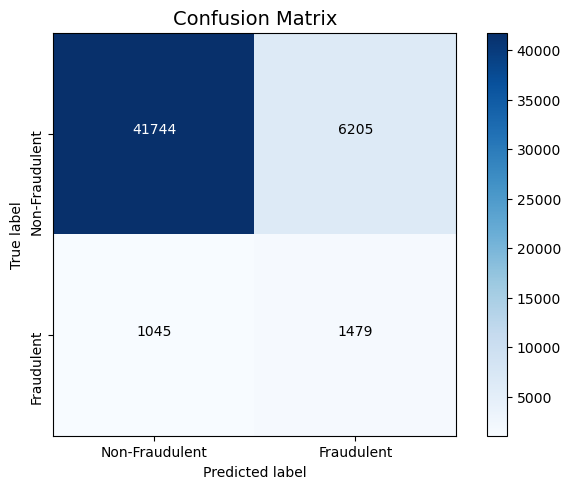

In [232]:
dt = DecisionTreeClassifier(random_state = 0, class_weight={1:10, 0:1}, min_samples_leaf = 100)
dt.fit(X_train,y_train)
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm)

In [233]:
our_score(dt, X_test, y_test)

-0.10853327708757292

In [234]:
retrieved_money(dt, X_test, y_test)

(-175677.85, -11227.850000000006, 103450.76000000001)

In [120]:
param = {
    "class_weight" : [{1:i, 0:1} for i in [1, 10, 20, 50]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30]
 }

model = DecisionTreeClassifier(random_state = 0)
CV_model = GridSearchCV(estimator=model, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model.fit(X_train, y_train)


Fitting 10 folds for each of 196 candidates, totalling 1960 fits
[CV 1/10; 1/196] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 1/10; 1/196] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1;, score=0.000 total time=   0.6s
[CV 2/10; 1/196] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 2/10; 1/196] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1;, score=0.000 total time=   0.6s
[CV 3/10; 1/196] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 3/10; 1/196] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1;, score=0.000 total time=   0.6s
[CV 4/10; 1/196] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 4/10; 1/196] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1;, score=0.000 total time=   0.5s
[CV 5/10; 1/196] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1
[CV 5/10; 1/196] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 10},
                                          {0: 1, 1: 20}, {0: 1, 1: 50}],
                         'max_depth': [1, 5, 10, 15, 20, 25, 30],
                         'min_samples_leaf': [1, 5, 10, 25, 50, 100, 200]},
             scoring=<function our_score at 0x7f20201952d0>, verbose=10)

In [121]:
print(CV_model.best_params_)

{'class_weight': {1: 10, 0: 1}, 'max_depth': 5, 'min_samples_leaf': 100}


In [122]:
print(CV_model.best_score_)

0.5922888931298017


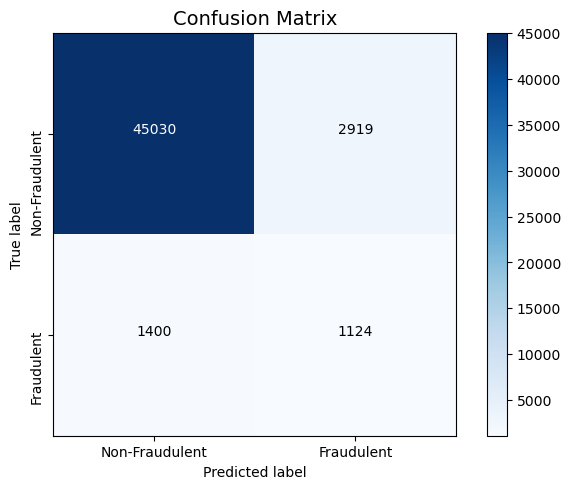

In [235]:
dt_opt = DecisionTreeClassifier(random_state = 0, class_weight={1:10, 0:1}, max_depth= 5, min_samples_leaf=100)
dt_opt.fit(X_train,y_train)
y_pred_dt = dt_opt.predict(X_test)
cm_dt_opt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt_opt)

In [236]:
f1_score(y_test,y_pred_dt)

0.3423176488503122

In [250]:
our_score(dt_opt, X_test, y_test)

0.6020330431017827

In [251]:
retrieved_money(dt_opt, X_test, y_test)

(-293332.17000000004, 157325.40000000002, 261323.53000000003)

In [280]:
param = {
    "class_weight" : [{1:i, 0:1} for i in [1, 10, 15, 20]],
    "min_samples_leaf" : [1, 5, 10, 25, 50, 100, 200],
    "max_depth" : [1, 5, 10, 15, 20, 25, 30],
    "n_estimators" : [10, 50, 100, 200, 300]
 }

model2 = RandomForestClassifier(random_state = 0, n_jobs = -1)
CV_model2 = GridSearchCV(estimator=model2, cv = kf, n_jobs = -1, param_grid = param, scoring = our_score,verbose=10)
CV_model2.fit(X_train, y_train)

Fitting 10 folds for each of 980 candidates, totalling 9800 fits
[CV 1/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 1/10; 1/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10;, score=0.000 total time=   0.3s
[CV 7/10; 3/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=100
[CV 3/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 4/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 6/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 5/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 7/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 2/10; 1/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=10
[CV 8/10; 1/

/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 8/10; 10/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5, n_estimators=300
[CV 9/10; 10/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5, n_estimators=300
[CV 3/10; 8/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5, n_estimators=100;, score=0.000 total time=   6.8s
[CV 7/10; 5/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=1, n_estimators=300;, score=0.000 total time=  17.3s
[CV 10/10; 10/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5, n_estimators=300
[CV 1/10; 8/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5, n_estimators=100;, score=0.000 total time=   7.3s
[CV 1/10; 11/980] START class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=10, n_estimators=10
[CV 4/10; 8/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_samples_leaf=5, n_estimators=100;, score=0.000 total time=   6.9s
[CV 6/10; 8/980] END class_weight={1: 1, 0: 1}, max_depth=1, min_sample